In [1]:
from pathlib import Path
import datetime
import json
import gzip
import gc
from itertools import chain
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import HBox, Checkbox, interactive_output

from itables import init_notebook_mode
from itables.widget import ITable



# Analysing Missing Data

In [2]:
import datetime
import pandas as pd
from zoneinfo import ZoneInfo
from pathlib import Path

RAW_DIR = Path("bmrs_csv_raw")
LOG_DIR = Path("logs")
FILLED_DIR = Path("bmrs_csv_filled")
GAP_CSV_DIR = LOG_DIR / "all_data_missing.csv"
KEY_COLS = ["startTime", "settlementDate", "settlementPeriod"]



def build_uk_halfhour_calendar(start_date, end_date):
    """
    Build UK half-hour calendar with correct DST handling:
      • Spring-forward days: 46 periods (including the skipped 01:00/01:30)
      • Normal days: 48 periods 00:00-23:30
      • BST days: 48 periods 23:00(prev day)-22:30
      • Autumn-back days: 50 periods 23:00(prev day)-22:30
    """

    def _to_date(x):
        if isinstance(x, str):
            
            if x.count("-") == 2 and x[4] == "-": # ISO format
                return datetime.date.fromisoformat(x)
            return datetime.datetime.strptime(x, "%d/%m/%Y").date() # UK format
        if isinstance(x, pd.Timestamp):
            return x.date()
        return x

    start = _to_date(start_date)
    end   = _to_date(end_date)

    london = ZoneInfo("Europe/London")
    utc    = ZoneInfo("UTC")
    rows   = []

    for single in pd.date_range(start, end, freq="D"):
        D   = single.date()
        # local midnights in London
        dt0 = datetime.datetime(D.year, D.month, D.day, tzinfo=london)
        dt1 = dt0 + datetime.timedelta(days=1)

        # number of half-hours that actually occur
        total_secs = (dt1.astimezone(utc) - dt0.astimezone(utc)).total_seconds()
        n_periods = int(total_secs // 1800)

        # align to UTC-naive base for SP1
        offset_h = dt0.utcoffset().total_seconds() / 3600
        if offset_h > 0:
            base = datetime.datetime(D.year, D.month, D.day) - datetime.timedelta(hours=int(offset_h))
        else:
            base = datetime.datetime(D.year, D.month, D.day)

        for i in range(n_periods):
            rows.append({
                "startTime":        base + datetime.timedelta(minutes=30 * i),
                "settlementDate":   D,
                "settlementPeriod": i + 1
            })

    df = pd.DataFrame(rows)

    # ─── coerce to pandas time types ───
    df["startTime"]      = pd.to_datetime(df["startTime"])
    df["settlementDate"] = pd.to_datetime(df["settlementDate"]).dt.normalize()
    df["settlementPeriod"] = df["settlementPeriod"].astype("int32")
    # ───────────────────────────────────

    return df

# 1) build a full DST-aware half-hour calendar
cal = build_uk_halfhour_calendar("01/01/2017", "31/05/2025")

skip_feeds = {"MID","INTER","SYSTEM_PRICES","GEN_PER_TYPE"} # feeds skipped due to full coverage or deliberate NaNs

# 2) for each feed, detect its missing-data runs and merge
for csv_path in sorted(RAW_DIR.glob("*.csv")):
    feed = csv_path.stem
    if feed in skip_feeds:
        continue

    print("Processing", feed)
    df = pd.read_csv(csv_path, dtype=str)

    df["startTime"]      = (
        pd.to_datetime(df["startTime"], utc=True, errors="coerce")
          .dt.tz_convert(None)
    )
    df["settlementDate"] = (
        pd.to_datetime(df["settlementDate"], dayfirst=True, errors="coerce")
          .dt.normalize()
    )
    df["settlementPeriod"] = df["settlementPeriod"].astype(int)

    # compute, row-wise, the list of missing data columns
    data_cols = [c for c in df.columns if c not in KEY_COLS]
    missing = (
        df[data_cols].isna()
        | (df[data_cols] == "")
    ).apply(lambda row: ";".join(row.index[row]), axis=1)

    # build the small DataFrame with exactly matching key dtypes
    small = df[KEY_COLS].copy()
    small[feed] = missing

    # merge on uniform dtypes (datetime64), fill & drop dupes
    cal = cal.merge(small, on=KEY_COLS, how="left")
    cal[feed] = cal[feed].fillna("")
    cal.drop_duplicates(subset=["startTime"], inplace=True)


# 3) save the combined missing-data report
cal.to_csv(GAP_CSV_DIR, index=False)
print("→ Written combined missing-data report to", GAP_CSV_DIR)

Processing ACTUAL_DEMAND
Processing ACTUAL_GEN_WIND_SOLAR
Processing DAYAHEAD_DEMAND
Processing DAYAHEAD_GEN_WIND_SOLAR
Processing INDICATED_DAYAHEAD_DEMAND
Processing LOLPDRM
Processing NONBM
→ Written combined missing-data report to logs/all_data_missing.csv


In [1]:
from pathlib import Path
import pandas as pd
from IPython.display import display, clear_output
import ipywidgets as widgets
from itables.widget import ITable

RAW_DIR = Path("bmrs_csv_raw")
LOG_DIR = Path("logs")
FILLED_DIR = Path("bmrs_csv_filled")
GAP_CSV_DIR = LOG_DIR / "all_data_missing.csv"
KEY_COLS = ["startTime", "settlementDate", "settlementPeriod"]

def gap_analysis(df: pd.DataFrame, time_col: str="startTime") -> pd.DataFrame:
    """
    Wide-form gap analysis:
      * index by gapSize
      * one column per series named <col>GapCount
      * each value = count of runs of that length
      * zeros where no runs of that size exist
    """
    # ensure chronological order & index on time_col
    df2 = df.sort_values(time_col).set_index(time_col)

    # pick every column except the three keys
    key_cols = {time_col, "settlementDate", "settlementPeriod"}
    candidate_cols = [c for c in df2.columns if c not in key_cols]

    rows = []
    for col in candidate_cols:
        ser   = pd.to_numeric(df2[col], errors="coerce")
        is_na = ser.isna()
        grp   = is_na.ne(is_na.shift()).cumsum()
        runlen = is_na.groupby(grp).sum()
        runlen = runlen[runlen > 0]
        counts = runlen.value_counts().sort_index()
        for gap_size, cnt in counts.items():
            rows.append({
                "column_name": col,
                "gap_size":    int(gap_size),
                "count":       int(cnt),
            })

    long = pd.DataFrame(rows)
    if long.empty:
        cols = ["gapSize"] + [f"{c}GapCount" for c in candidate_cols]
        return pd.DataFrame(columns=cols)

    wide = (
        long
        .pivot(index="gap_size", columns="column_name", values="count")
        .fillna(0)
        .astype(int)
        .reset_index()
        .rename(columns={"gap_size": "gapSize"})
    )
    wide.columns = [
        c if c == "gapSize" else f"{c}GapCount"
        for c in wide.columns
    ]
    return wide

# ──────────────────────────────────────────────────────────────────────────

# prepare list of feeds
skip_feeds = {""}
paths      = sorted(RAW_DIR.glob("*.csv"))

# load raw DataFrames for each feed
dataframes, titles = [], []
for p in paths:
    name = p.stem
    if name in skip_feeds:
        continue
    df = pd.read_csv(p, parse_dates=["startTime"])
    dataframes.append(df)
    titles.append(name)

# create one Output per feed, and a Tab container
outs = [widgets.Output() for _ in dataframes]
tab  = widgets.Tab(children=outs)
for i, title in enumerate(titles):
    tab.set_title(i, title)

# callback: build and display the ITable when tab is selected
def _on_tab_change(change):
    if change["name"] != "selected_index":
        return
    idx = change["new"]
    df  = dataframes[idx]
    gaps = gap_analysis(df)
    out  = outs[idx]
    with out:
        clear_output(wait=True)
        tbl = ITable(
            gaps,
            classes="display nowrap",
            paging=False,   # disable pagination
            layout={        # remove all the UI controls
                "topStart":    None,  # no length-menu
                "topEnd":      None,  # no search box
                "bottomStart": None,  # no info text
                "bottomEnd":   None,  # no paging controls
            },
            scrollX=True
        )
        display(tbl)

tab.observe(_on_tab_change, names="selected_index")

# trigger initial display of the first tab
tab.selected_index = 1

# render the tabs
display(tab)


In [5]:
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import Checkbox, GridBox, HTML, Output, Layout
from IPython.display import display
from pathlib import Path

RAW_DIR = Path("bmrs_csv_raw")
LOG_DIR = Path("logs")
FILLED_DIR = Path("bmrs_csv_filled")
GAP_CSV_DIR = LOG_DIR / "all_data_missing.csv"
KEY_COLS = ["startTime", "settlementDate", "settlementPeriod"]

ignore_cols = {'settlementDate', 'settlementPeriod'}
feed_files = sorted(
    [p for p in RAW_DIR.glob('*.csv')],
    key=lambda p: p.stem
)

col_checkbox_pairs = []
checkboxes = []

# Build a flat list of styled checkboxes
for p in feed_files:
    feed = p.stem
    df = (pd.read_csv(p, parse_dates=['startTime'])
            .set_index('startTime'))
    for col in df.columns:
        if col in ignore_cols:
            continue
        cb = Checkbox(
            value=False,
            description=f"{feed}: {col}",
            style={'description_width': 'initial'},      # allow full label
            layout=Layout(width='100%', min_width='200px')  # at least 200px wide
        )
        cb.observe(lambda change: update_plot(), names='value')
        col_checkbox_pairs.append((feed, col, cb))
        checkboxes.append(cb)

# Put them in a 3-column grid
checkbox_container = GridBox(
    children=checkboxes,
    layout=Layout(
        display='grid',
        grid_template_columns='repeat(3, 1fr)',  # 3 equal columns
        grid_gap='4px 8px',                      # gap between rows/cols
        max_height='400px',
        overflow_y='auto',
        border='1px solid lightgray',
        padding='4px'
    )
)

out = Output()

def update_plot():
    fig = go.Figure()
    for feed, col, cb in col_checkbox_pairs:
        if not cb.value:
            continue
        df = (pd.read_csv(RAW_DIR / f"{feed}.csv", parse_dates=['startTime'])
                .set_index('startTime'))
        y = pd.to_numeric(df[col], errors='coerce')
        fig.add_trace(go.Scatter(
            x=df.index, y=y, mode='lines', name=f"{feed}: {col}"
        ))
        missing = y[y.isna()].index
        if len(missing):
            fig.add_trace(go.Scatter(
                x=missing,
                y=y.ffill().loc[missing],
                mode='markers',
                marker=dict(color='red', size=6),
                name=f'{feed}: {col} missing'
            ))
    fig.update_layout(
        title='Selected Series',
        xaxis_title='Time',
        yaxis_title='Value',
        height=800,
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='left',
            x=0
        )
    )
    with out:
        out.clear_output(wait=True)
        display(fig)

# Initialise and display
update_plot()
display(HTML("<b>Select series to plot:</b>"), checkbox_container, out)


HTML(value='<b>Select series to plot:</b>')

GridBox(children=(Checkbox(value=False, description='ACTUAL_DEMAND: initialDemandOutturn', layout=Layout(min_w…

Output()

# Seasonal Imputation

* All small gaps ($\leq 2 \text{ SP}$) are interpolated

* All feeds are imputed seasonally, apart from `NONBM/generation` and `1hLOLP`, which have gaps filled with `0` (as they have no seasonality)

In [8]:
import os
from pathlib import Path

# 0) Max out BLAS threads before imports
n = os.cpu_count()
for k in ("OMP_NUM_THREADS", "MKL_NUM_THREADS", "OPENBLAS_NUM_THREADS"):
    os.environ[k] = str(n)

import pandas as pd
from statsmodels.tsa.seasonal import STL
from joblib import Parallel, delayed
import numpy as np

# Directories
RAW_DIR    = Path("bmrs_csv_raw")
FILLED_DIR = Path("bmrs_csv_filled")
FILLED_DIR.mkdir(exist_ok=True)

# Load GEN_PER_TYPE as tool DataFrame for copy-and-delete
gen_per_type = (
    pd.read_csv(RAW_DIR/"GEN_PER_TYPE.csv", parse_dates=["startTime"])
      .set_index("startTime")
)

# STL parameters per feed
stl_params = {
    "ACTUAL_DEMAND":             dict(period=48, seasonal=97, trend=337, robust=False),
    "ACTUAL_GEN_WIND_SOLAR":     dict(period=48, seasonal=97, trend=337, robust=True),
    "DAYAHEAD_DEMAND":           dict(period=48, seasonal=97, trend=337, robust=False),
    "DAYAHEAD_GEN_WIND_SOLAR":   dict(period=48, seasonal=97, trend=337, robust=True),
    "GEN_PER_TYPE":              dict(period=48, seasonal=97, trend=337, robust=False),
    "INDICATED_DAYAHEAD_DEMAND": dict(period=48, seasonal=97, trend=337, robust=False),
    "INTER":                     dict(period=48, seasonal=97, trend=337, robust=False),
    "LOLPDRM":                   dict(period=48, seasonal=97, trend=337, robust=False),
    "MID":                       dict(period=48, seasonal=31, trend=193, robust=False),
    "SYSTEM_PRICES":             dict(period=48, seasonal=31, trend=193, robust=False),
    "NONBM":                     dict(period=48, seasonal=97, trend=337, robust=False),
}

# Exception sets
zero_fill_exceptions = {
    ("LOLPDRM", "1hLOLP"),
    ("NONBM",   "generation")
}
ignore_nans_exceptions = {
    ("SYSTEM_PRICES", "replacementPriceReferenceVolume"),
    ("SYSTEM_PRICES", "replacementPrice"),
    ("SYSTEM_PRICES","totalSystemTaggedAdjustmentSellVolume"),
    ("SYSTEM_PRICES","totalSystemTaggedAdjustmentBuyVolume")
}
negative_clip_exceptions = {
    ("GEN_PER_TYPE", "*"),
    ("INDICATED_DAYAHEAD_DEMAND", "*"),
    ("LOLPDRM", "*"),
    ("MID",      "volume"),
    ("NONBM",    "generation"),
    ("SYSTEM_PRICES","totalAdjustmentBuyVolume"),
    ("SYSTEM_PRICES","totalSystemTaggedAcceptedOfferVolume"),
    ("ACTUAL_GEN_WIND_SOLAR", "*"),
    ("DAYAHEAD_GEN_WIND_SOLAR", "*"),
}
positive_clip_exceptions = {
    ("SYSTEM_PRICES","totalAcceptedBidVolume"),
    ("SYSTEM_PRICES","totalAdjustmentSellVolume"),
    ("SYSTEM_PRICES","totalSystemTaggedAcceptedBidVolume")
}
multiplicative_feeds = {
    ("ACTUAL_GEN_WIND_SOLAR", "*"),
    ("DAYAHEAD_GEN_WIND_SOLAR", "*"),
}

# Helper functions
def fill_small_gaps(df, time_col="startTime", limit=2):
    out = df.sort_values(time_col).set_index(time_col)
    num = out.select_dtypes("number")
    full = num.interpolate(method="time", limit=None, limit_direction="both")
    for col in num:
        is_na  = out[col].isna()
        grp    = (is_na != is_na.shift()).cumsum()
        runlen = is_na.groupby(grp).transform("sum")
        can    = is_na & (runlen <= limit)
        out.loc[can, col] = full.loc[can, col]
    return out.reset_index()

def seasonal_impute_additive(series, period, seasonal, trend, robust):
    pre = series.interpolate("time", limit_area="inside").ffill().bfill()
    res = STL(pre, period=period, seasonal=seasonal, trend=trend, robust=robust).fit()
    return res.trend + res.seasonal

def seasonal_impute_multiplicative(series, period, seasonal, trend, robust):
    # Multiplicative (log1p→STL→expm1) imputation
    pre = series.interpolate("time", limit_area="inside").ffill().bfill()
    pre = pre.clip(lower=0)                   # floor at zero
    logged = np.log1p(pre)                    # log(1 + x)
    res = STL(logged, period=period,
                     seasonal=seasonal,
                     trend=trend,
                     robust=robust).fit()
    return np.expm1(res.trend + res.seasonal)# expm1 back to original scale

def zero_fill(series):
    first = series.first_valid_index()
    if first is None:
        return series
    after = series.loc[first:].fillna(0)
    return series.combine_first(after)



# Main processing function
def process_file(csv_path):
    feed = csv_path.stem.upper()
    df   = pd.read_csv(csv_path, parse_dates=["startTime"]).set_index("startTime")

    # 1) small-gap interpolate (≤2)
    df2 = fill_small_gaps(df.reset_index(), time_col="startTime").set_index("startTime")

    # 2) STL/zero-fill/clip for remaining gaps
    for col in df2.select_dtypes("number"):
        key = (feed, col)
        if key in ignore_nans_exceptions:
            continue
        if key in zero_fill_exceptions:
            df2[col] = zero_fill(df2[col])
            continue

        orig   = df[col]
        is_na  = orig.isna()
        grp    = (is_na != is_na.shift()).cumsum()
        runlen = is_na.groupby(grp).transform("sum")
        allowed = is_na & (runlen <= 336)
        if not allowed.any():
            continue

        params   = stl_params.get(feed, {"period":48,"seasonal":97,"trend":337,"robust":False})

        # choose imputer based on your multiplicative_feeds set
        if (feed, "*") in multiplicative_feeds:
            baseline = seasonal_impute_multiplicative(df2[col], **params)
        else:
            baseline = seasonal_impute_additive(df2[col], **params)

        # safety clips
        if (feed, "*") in negative_clip_exceptions or key in negative_clip_exceptions:
            baseline = baseline.clip(lower=0)
        elif (feed, "*") in positive_clip_exceptions or key in positive_clip_exceptions:
            baseline = baseline.clip(upper=0)

        df2.loc[allowed, col] = baseline.loc[allowed]

    # 3) Save
    df2.to_csv(FILLED_DIR/csv_path.name)
    return f"Saved {csv_path.name}"

# Gather and sort CSV paths alphabetically
paths = sorted(RAW_DIR.glob("*.csv"), key=lambda p: p.stem.upper())
# paths = [p for p in paths if p.stem.upper() in {"DAYAHEAD_GEN_WIND_SOLAR", "ACTUAL_GEN_WIND_SOLAR"}]

# Parallel execution
results = Parallel(n_jobs=-1, verbose=5)(
    delayed(process_file)(p) for p in paths
)

print("\n".join(results))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:   21.4s remaining:   37.4s
[Parallel(n_jobs=-1)]: Done   7 out of  11 | elapsed:   49.5s remaining:   28.3s


Saved ACTUAL_DEMAND.csv
Saved ACTUAL_GEN_WIND_SOLAR.csv
Saved DAYAHEAD_DEMAND.csv
Saved DAYAHEAD_GEN_WIND_SOLAR.csv
Saved GEN_PER_TYPE.csv
Saved INDICATED_DAYAHEAD_DEMAND.csv
Saved INTER.csv
Saved LOLPDRM.csv
Saved MID.csv
Saved NONBM.csv
Saved SYSTEM_PRICES.csv


[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:  2.2min finished


### Viewing the Imputations

In [2]:
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import Checkbox, GridBox, HTML, Output, Layout
from IPython.display import display

ignore_cols = {'settlementDate', 'settlementPeriod'}
feed_files = sorted(
    [p for p in RAW_DIR.glob('*.csv')],
    key=lambda p: p.stem
)

col_checkbox_pairs = []
checkboxes = []

# Build a flat list of styled checkboxes
for p in feed_files:
    feed = p.stem
    df = (pd.read_csv(p, parse_dates=['startTime'])
            .set_index('startTime'))
    for col in df.columns:
        if col in ignore_cols:
            continue
        cb = Checkbox(
            value=False,
            description=f"{feed}: {col}",
            style={'description_width': 'initial'},      # allow full label
            layout=Layout(width='100%', min_width='200px')  # at least 200px wide
        )
        cb.observe(lambda change: update_plot(), names='value')
        col_checkbox_pairs.append((feed, col, cb))
        checkboxes.append(cb)

# Put them in a 3-column grid
checkbox_container = GridBox(
    children=checkboxes,
    layout=Layout(
        display='grid',
        grid_template_columns='repeat(3, 1fr)',  # 3 equal columns
        grid_gap='4px 8px',                      # gap between rows/cols
        max_height='400px',
        overflow_y='auto',
        border='1px solid lightgray',
        padding='4px'
    )
)

out = Output()

def update_plot():
    fig = go.Figure()
    for feed, col, cb in col_checkbox_pairs:
        if not cb.value:
            continue

        raw_path = RAW_DIR / f"{feed}.csv"
        filled_path = FILLED_DIR / f"{feed}.csv"

        # Load raw and filled
        df_raw = pd.read_csv(raw_path, parse_dates=['startTime']).set_index('startTime')
        df_filled = pd.read_csv(filled_path, parse_dates=['startTime']).set_index('startTime')

        y_raw = pd.to_numeric(df_raw[col], errors='coerce')
        y_filled = pd.to_numeric(df_filled[col], errors='coerce')

        # Plot filled line (includes both original + imputed values)
        fig.add_trace(go.Scatter(
            x=y_filled.index,
            y=y_filled,
            mode='lines',
            name=f"{feed}: {col} (filled)"
        ))

        # Identify and plot just the imputed values (where raw was missing)
        missing_idx = y_raw[y_raw.isna()].index
        if len(missing_idx):
            imputed_vals = y_filled.loc[missing_idx]

            fig.add_trace(go.Scatter(
                x=imputed_vals.index,
                y=imputed_vals.values,
                mode='markers',
                marker=dict(color='green', size=6, symbol='circle'),
                name=f'{feed}: {col} imputed'
            ))

    fig.update_layout(
        title='Selected Series (Filled)',
        xaxis_title='Time',
        yaxis_title='Value',
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='left',
            x=0
        )
    )
    with out:
        out.clear_output(wait=True)
        display(fig)



# Initialise and display
update_plot()
display(HTML("<b>Select series to plot:</b>"), checkbox_container, out)


HTML(value='<b>Select series to plot:</b>')

GridBox(children=(Checkbox(value=False, description='ACTUAL_DEMAND: initialDemandOutturn', layout=Layout(min_w…

Output()

### ACF and PACF Plotter

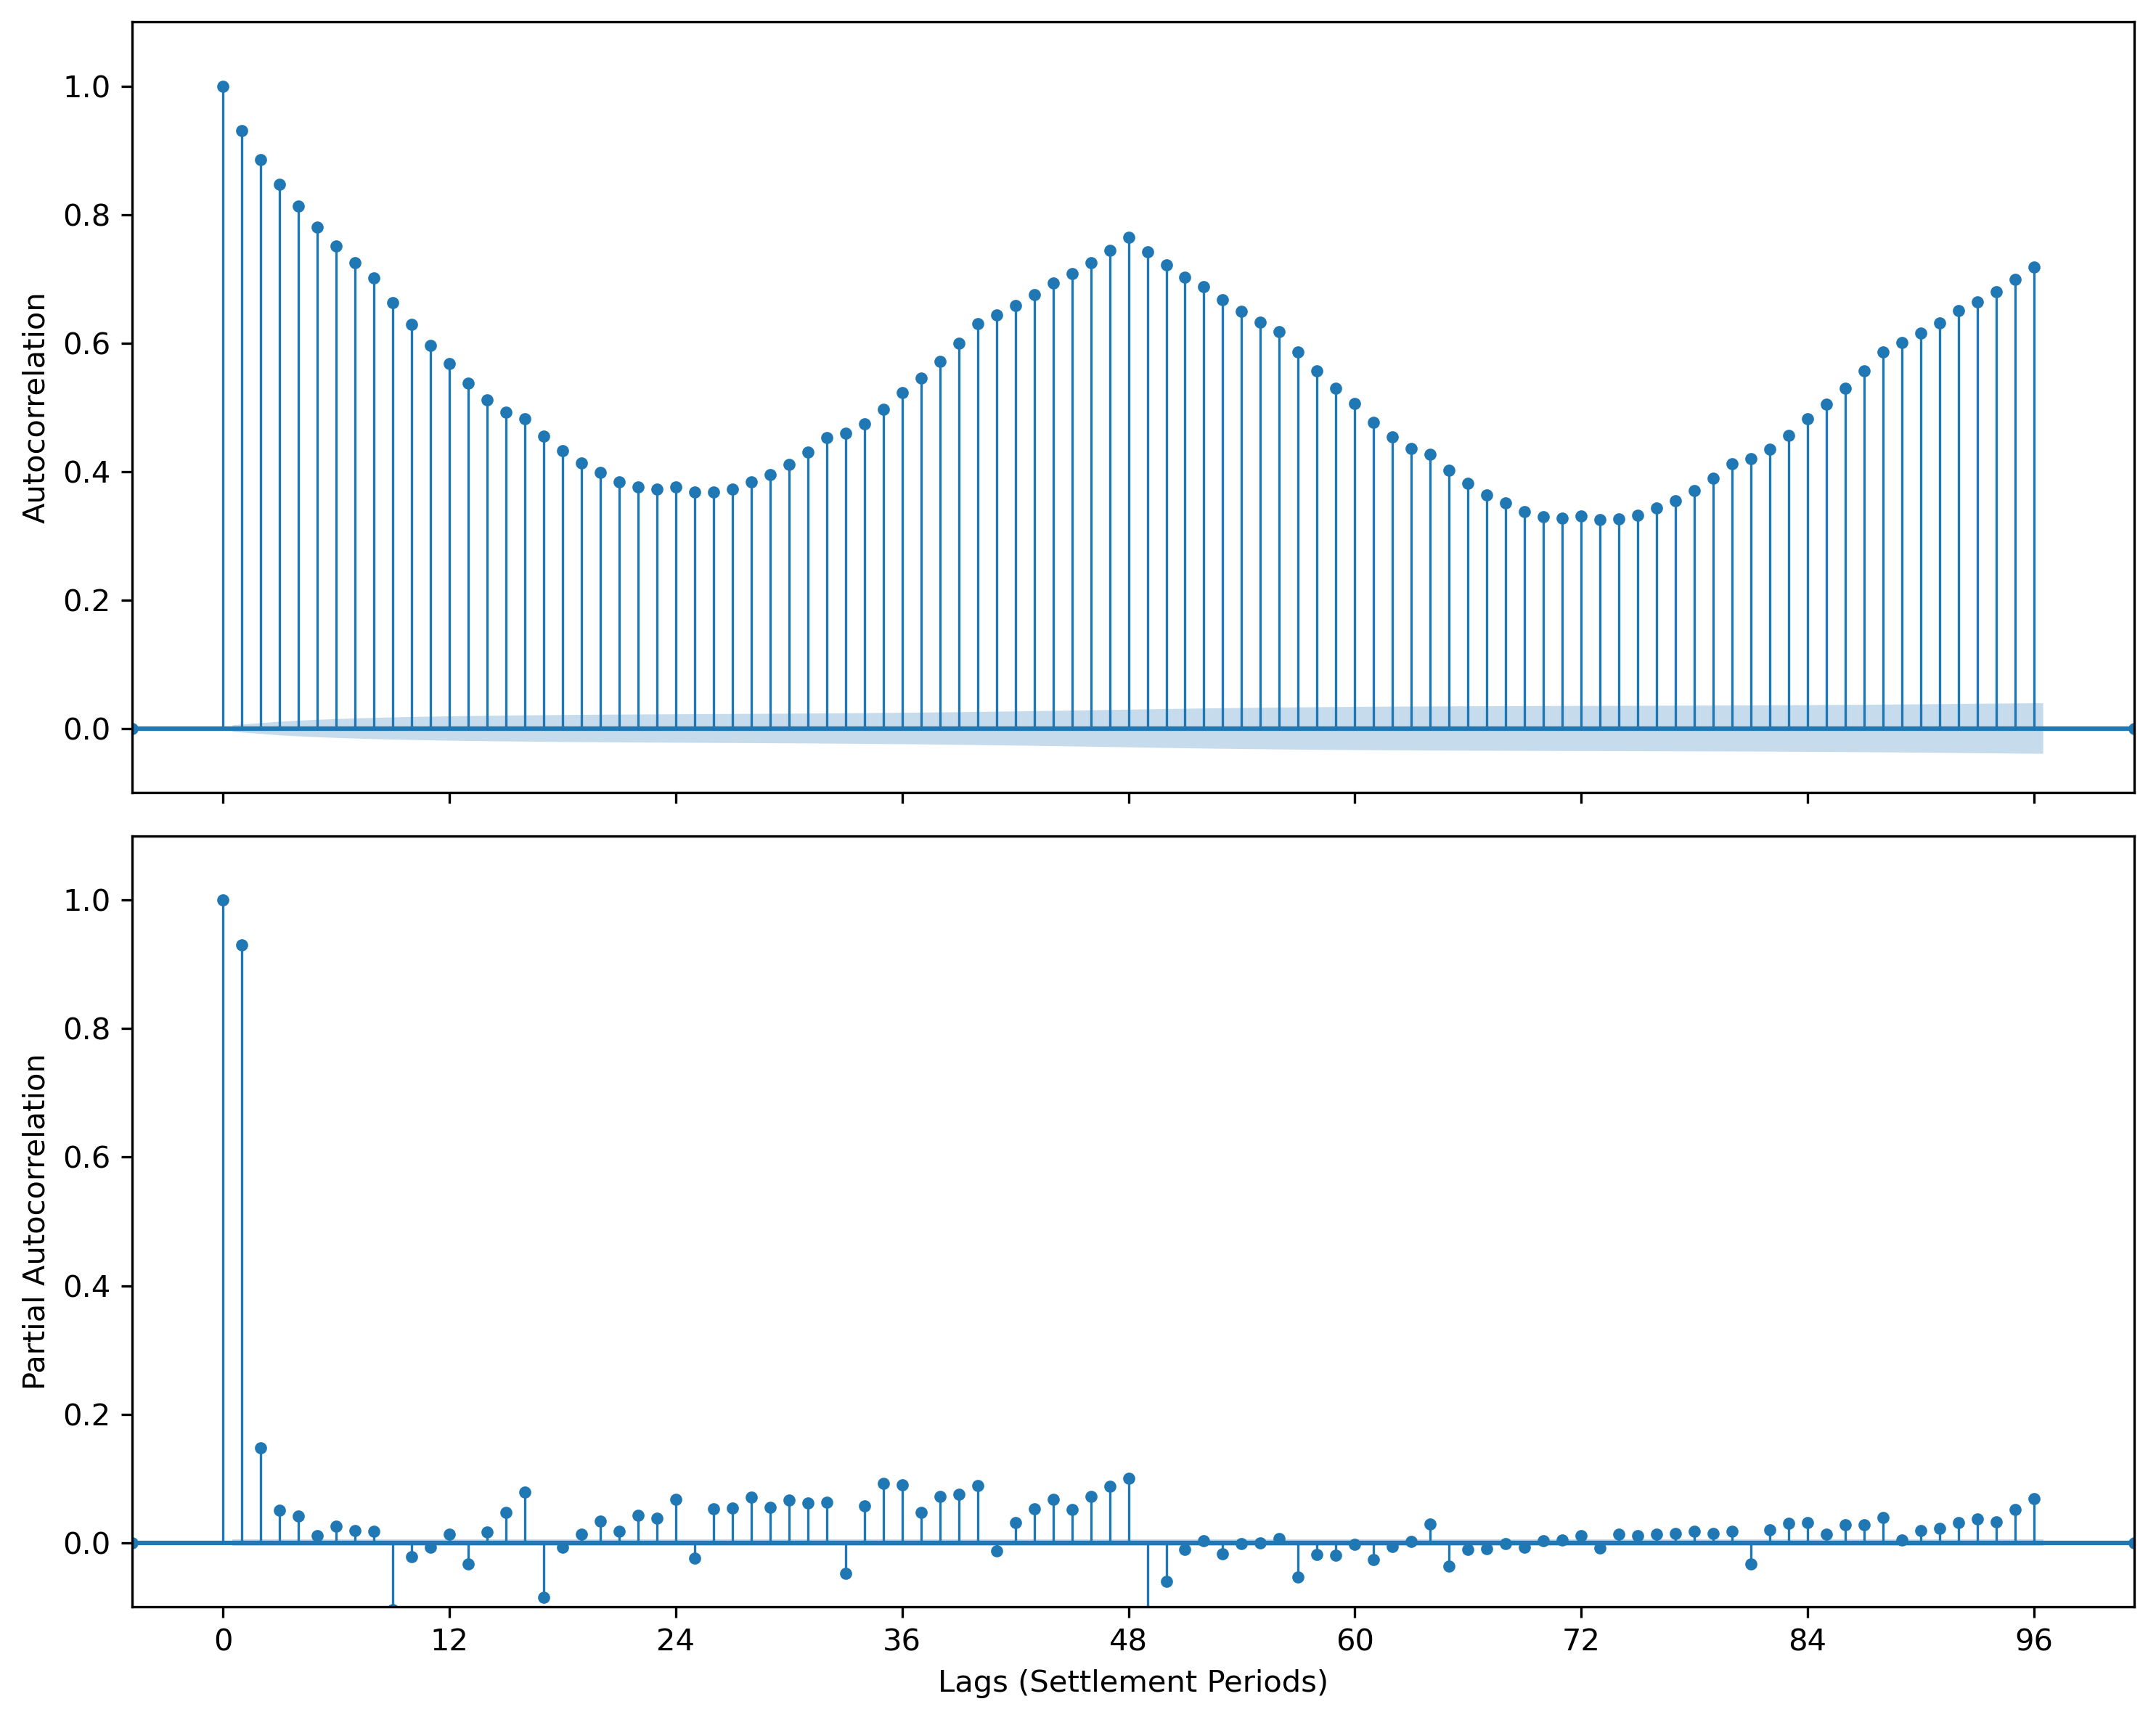

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_feed = "MID.csv"
plot_column = "volume"

file = pd.read_csv(FILLED_DIR/plot_feed).set_index("startTime")
df = file[plot_column]

fig, axes = plt.subplots(2, 1, figsize=(10, 8), dpi=300)

# ACF plot
plot_acf(
    df,
    lags=96,
    ax=axes[0],
    marker='o',
    markersize=3,
    vlines_kwargs={'linewidth': 0.8},
)
axes[0].set_ylabel("Autocorrelation")
axes[0].set_ylim(-0.1, 1.1)
axes[0].set_xticks(np.arange(0, 97, 12))
axes[0].tick_params(axis='x', labelbottom=False)
axes[0].set_title(None)

# PACF plot
plot_pacf(
    df,
    lags=96,
    ax=axes[1],
    method='ywm',
    marker='o',
    markersize=3,
    vlines_kwargs={'linewidth': 0.8},
)
axes[1].set_ylabel("Partial Autocorrelation")
axes[1].set_ylim(-0.1, 1.1)
axes[1].set_xticks(np.arange(0, 97, 12))
axes[1].set_xlabel("Lags (Settlement Periods)")
axes[1].set_title(None)

plt.tight_layout()
plt.show()



# Iterative Imputer

## DAYAHEAD

### OFFSHORE

In [10]:
import pandas as pd
from pathlib import Path
from joblib import parallel_backend
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import BayesianRidge

# Directories
RAW    = Path("bmrs_csv_raw")
FILLED = Path("bmrs_csv_filled")

# Helper to load predictors
def load_predictor(fname, cols):
    for base in (FILLED, RAW):
        p = base / fname
        if p.exists():
            return (pd.read_csv(p, parse_dates=["startTime"])
                      .set_index("startTime")[cols])
    raise FileNotFoundError(f"Cannot find {fname}")

# Load everything
datetime = load_predictor("MID.csv", ["settlementPeriod"])
mid      = load_predictor("MID.csv", ["price", "volume"])
sysp     = load_predictor("SYSTEM_PRICES.csv", ["systemPrice", "netImbalanceVolume"])
gpt      = load_predictor("GEN_PER_TYPE.csv", ["fossilGas", "hydroPumpedStorage"])
adem     = load_predictor("ACTUAL_DEMAND.csv", ["initialTransmissionSystemDemandOutturn"])
drm      = load_predictor("LOLPDRM.csv", ["1hDRM"])

da_offshore      = (pd.read_csv(RAW/"DAYAHEAD_GEN_WIND_SOLAR.csv", parse_dates=["startTime"])
              .set_index("startTime")[["windOffshoreGeneration"]])

# Build full half‑hourly DF, then shift all actual predictors back 48 half‑hours
df_full = pd.concat([da_offshore, datetime, mid, sysp, gpt, adem, drm], axis=1)
static_cols = [c for c in df_full.columns if c != "windOffshoreGeneration"]
actual_feats = df_full[static_cols].shift(48)

# Now combine your day‑ahead target with those shifted predictors
df_impute = pd.concat([da_offshore, actual_feats], axis=1)

# Finally downsample to hourly (every other half‑hour)
df_hr = df_impute.iloc[::2].copy()

param_grid = [
    # # very shallow, big leaves, tiny feature subset
    # { "max_depth": 2,
    #   "min_samples_split": 50,
    #   "min_samples_leaf": 20,
    #   "max_leaf_nodes": 10,
    #   "n_estimators": 500,
    #   "max_features": 0.3
    # },
    # # slightly deeper, still heavy regularisation
    # { "max_depth": 3,
    #   "min_samples_split": 30,
    #   "min_samples_leaf": 15,
    #   "max_leaf_nodes": 15,
    #   "n_estimators": 500,
    #   "max_features": "sqrt"
    # },
    # # medium‑depth, medium regularisation
    # { "max_depth": 5,
    #   "min_samples_split": 20,
    #   "min_samples_leaf": 10,
    #   "max_leaf_nodes": 20,
    #   "n_estimators": 300,
    #   "max_features": "log2"
    # },
    # # deeper but big leaf size
    # { "max_depth": 8,
    #   "min_samples_split": 50,
    #   "min_samples_leaf": 20,
    #   "max_leaf_nodes": 25,
    #   "n_estimators": 200,
    #   "max_features": 0.5
    # },
    # fallback: very large forest but small depth
    { "max_depth": 3,
      "min_samples_split": 10,
      "min_samples_leaf": 5,
      "max_leaf_nodes": 30,
      "n_estimators": 1000,
      "max_features": "sqrt"
    },
]


results_da_offshore = []
for i, params in enumerate(param_grid, 1):
    print(f"Combo {i}/{len(param_grid)} – testing {params}")

    rf = RandomForestRegressor(random_state=0, n_jobs=-1, **params)
    imp = IterativeImputer(
        estimator=rf,
        max_iter=10,
        initial_strategy="median",
        random_state=0,
        verbose=2
    )

    # ---- 1) Impute on the hourly DataFrame ----
    with parallel_backend("loky", n_jobs=-1):
        arr_hr = imp.fit_transform(df_hr)
    df_hr_imp = pd.DataFrame(arr_hr, index=df_hr.index, columns=df_full.columns)

    # ---- 2) Rebuild half‑hourly DF ----
    df_imp = pd.DataFrame(index=df_full.index, columns=df_full.columns)

    # a) fill in the imputed hourly values
    df_imp.loc[df_hr_imp.index] = df_hr_imp

    # b) re‑insert original static predictors at the odd half‑hours
    df_imp[static_cols] = df_imp[static_cols].fillna(df_full[static_cols])

    # c) forward‑fill the wind series to get pseudo‑half‑hourly
    df_imp["windOffshoreGeneration"] = df_imp["windOffshoreGeneration"].astype(float).ffill()

    mask_missing = df_full["windOffshoreGeneration"].isna()

    results_da_offshore.append((
        params,
        df_imp["windOffshoreGeneration"],  # <-- just the imputed wind series
        mask_missing                       # <-- the boolean mask of imputed slots
    ))


import joblib
IMP_DIR = Path("imputed_wind")
IMP_DIR.mkdir(exist_ok=True)
joblib.dump(results_da_offshore, IMP_DIR/"results_da_offshore.joblib")


Combo 1/1 – testing {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_leaf_nodes': 30, 'n_estimators': 1000, 'max_features': 'sqrt'}
[IterativeImputer] Completing matrix with shape (74471, 10)
[IterativeImputer] Ending imputation round 1/10, elapsed time 51.76
[IterativeImputer] Change: 3399.925632263175, scaled tolerance: 51.506 
[IterativeImputer] Ending imputation round 2/10, elapsed time 99.62
[IterativeImputer] Change: 3176.354968689603, scaled tolerance: 51.506 
[IterativeImputer] Ending imputation round 3/10, elapsed time 146.80
[IterativeImputer] Change: 2496.661239652759, scaled tolerance: 51.506 
[IterativeImputer] Ending imputation round 4/10, elapsed time 193.95
[IterativeImputer] Change: 5114.0697462101125, scaled tolerance: 51.506 
[IterativeImputer] Ending imputation round 5/10, elapsed time 240.84
[IterativeImputer] Change: 3060.8262536333705, scaled tolerance: 51.506 
[IterativeImputer] Ending imputation round 6/10, elapsed time 287.90
[IterativeImp

['imputed_wind/results_da_offshore.joblib']

### ONSHORE

In [11]:
import pandas as pd
from pathlib import Path
from joblib import parallel_backend
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import BayesianRidge

# Directories
RAW    = Path("bmrs_csv_raw")
FILLED = Path("bmrs_csv_filled")

# Helper to load predictors
def load_predictor(fname, cols):
    for base in (FILLED, RAW):
        p = base / fname
        if p.exists():
            return (pd.read_csv(p, parse_dates=["startTime"])
                      .set_index("startTime")[cols])
    raise FileNotFoundError(f"Cannot find {fname}")

# Load everything
datetime = load_predictor("MID.csv", ["settlementPeriod"])
mid      = load_predictor("MID.csv", ["price", "volume"])
sysp     = load_predictor("SYSTEM_PRICES.csv", ["systemPrice", "netImbalanceVolume"])
gpt      = load_predictor("GEN_PER_TYPE.csv", ["fossilGas", "hydroPumpedStorage"])
adem     = load_predictor("ACTUAL_DEMAND.csv", ["initialTransmissionSystemDemandOutturn"])
drm      = load_predictor("LOLPDRM.csv", ["1hDRM"])

da_onshore = (
    pd.read_csv(RAW/"DAYAHEAD_GEN_WIND_SOLAR.csv", parse_dates=["startTime"])
      .set_index("startTime")[["windOnshoreGeneration"]]
)

# Build full half‑hourly DF, then shift all actual predictors back 48 half‑hours
df_full = pd.concat([da_onshore, datetime, mid, sysp, gpt, adem, drm], axis=1)
static_cols = [c for c in df_full.columns if c != "windOnshoreGeneration"]
actual_feats = df_full[static_cols].shift(48)

# Combine the day‑ahead target with shifted predictors
df_impute = pd.concat([da_onshore, actual_feats], axis=1)

# Downsample to hourly (every other half‑hour)
df_hr = df_impute.iloc[::2].copy()

# Hyperparameter grid (unchanged)
param_grid = [
    # very shallow, big leaves, tiny feature subset
    { "max_depth": 2,
      "min_samples_split": 50,
      "min_samples_leaf": 20,
      "max_leaf_nodes": 10,
      "n_estimators": 500,
      "max_features": 0.3
    },
    # # slightly deeper, still heavy regularisation
    # { "max_depth": 3,
    #   "min_samples_split": 30,
    #   "min_samples_leaf": 15,
    #   "max_leaf_nodes": 15,
    #   "n_estimators": 500,
    #   "max_features": "sqrt"
    # },
    # # medium‑depth, medium regularisation
    # { "max_depth": 5,
    #   "min_samples_split": 20,
    #   "min_samples_leaf": 10,
    #   "max_leaf_nodes": 20,
    #   "n_estimators": 300,
    #   "max_features": "log2"
    # },
    # # deeper but big leaf size
    # { "max_depth": 8,
    #   "min_samples_split": 50,
    #   "min_samples_leaf": 20,
    #   "max_leaf_nodes": 25,
    #   "n_estimators": 200,
    #   "max_features": 0.5
    # },
    # # fallback: very large forest but small depth
    # { "max_depth": 3,
    #   "min_samples_split": 10,
    #   "min_samples_leaf": 5,
    #   "max_leaf_nodes": 30,
    #   "n_estimators": 1000,
    #   "max_features": "sqrt"
    # },
]

results_da_onshore = []
for i, params in enumerate(param_grid, 1):
    print(f"Combo {i}/{len(param_grid)} – testing {params}")

    rf = RandomForestRegressor(random_state=0, n_jobs=-1, **params)
    imp = IterativeImputer(
        estimator=rf,
        max_iter=10,
        initial_strategy="median",
        random_state=0,
        verbose=2
    )

    # ---- 1) Impute on the hourly DataFrame ----
    with parallel_backend("loky", n_jobs=-1):
        arr_hr = imp.fit_transform(df_hr)
    df_hr_imp = pd.DataFrame(arr_hr, index=df_hr.index, columns=df_full.columns)

    # ---- 2) Rebuild half‑hourly DF ----
    df_imp = pd.DataFrame(index=df_full.index, columns=df_full.columns)

    # a) fill in the imputed hourly values
    df_imp.loc[df_hr_imp.index] = df_hr_imp

    # b) re‑insert original static predictors at the odd half‑hours
    df_imp[static_cols] = df_imp[static_cols].fillna(df_full[static_cols])

    # c) forward‑fill the wind series to get pseudo‑half‑hourly
    df_imp["windOnshoreGeneration"] = df_imp["windOnshoreGeneration"].astype(float).ffill()

    mask_missing = df_full["windOnshoreGeneration"].isna()

    results_da_onshore.append((
        params,
        df_imp["windOnshoreGeneration"],  # just the imputed wind series
        mask_missing                      # boolean mask of imputed slots
    ))

# Save results
import joblib
IMP_DIR = Path("imputed_wind")
IMP_DIR.mkdir(exist_ok=True)
joblib.dump(results_da_onshore, IMP_DIR/"results_da_onshore.joblib")


Combo 1/1 – testing {'max_depth': 2, 'min_samples_split': 50, 'min_samples_leaf': 20, 'max_leaf_nodes': 10, 'n_estimators': 500, 'max_features': 0.3}
[IterativeImputer] Completing matrix with shape (74471, 10)
[IterativeImputer] Ending imputation round 1/10, elapsed time 14.05
[IterativeImputer] Change: 3348.1437154651003, scaled tolerance: 51.506 
[IterativeImputer] Ending imputation round 2/10, elapsed time 27.83
[IterativeImputer] Change: 5166.26211855265, scaled tolerance: 51.506 
[IterativeImputer] Ending imputation round 3/10, elapsed time 41.27
[IterativeImputer] Change: 5464.004411483966, scaled tolerance: 51.506 
[IterativeImputer] Ending imputation round 4/10, elapsed time 54.95
[IterativeImputer] Change: 846.2745910296886, scaled tolerance: 51.506 
[IterativeImputer] Ending imputation round 5/10, elapsed time 68.65
[IterativeImputer] Change: 30.410656164680056, scaled tolerance: 51.506 
[IterativeImputer] Early stopping criterion reached.


['imputed_wind/results_da_onshore.joblib']

### TOTAL

In [12]:
import pandas as pd
from pathlib import Path
from joblib import parallel_backend
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Directories
RAW    = Path("bmrs_csv_raw")
FILLED = Path("bmrs_csv_filled")

# Helper to load predictors
def load_predictor(fname, cols):
    for base in (FILLED, RAW):
        p = base / fname
        if p.exists():
            return (pd.read_csv(p, parse_dates=["startTime"])
                      .set_index("startTime")[cols])
    raise FileNotFoundError(f"Cannot find {fname}")

# Load everything
datetime = load_predictor("MID.csv", ["settlementPeriod"])
mid      = load_predictor("MID.csv", ["price", "volume"])
sysp     = load_predictor("SYSTEM_PRICES.csv", ["systemPrice", "netImbalanceVolume"])
gpt      = load_predictor("GEN_PER_TYPE.csv", ["fossilGas", "hydroPumpedStorage"])
adem     = load_predictor("ACTUAL_DEMAND.csv", ["initialTransmissionSystemDemandOutturn"])
drm      = load_predictor("LOLPDRM.csv", ["1hDRM"])

# Load the actual wind series and build total generation column
df = (
    pd.read_csv(RAW/"DAYAHEAD_GEN_WIND_SOLAR.csv", parse_dates=["startTime"])
      .set_index("startTime")[["windOffshoreGeneration", "windOnshoreGeneration"]]
)
df["windTotalGeneration"] = df.sum(axis=1, skipna=False)
da_total = df["windTotalGeneration"]

# Build full half‑hourly DF, then shift all actual predictors back 48 half‑hours
df_full = pd.concat([da_total, datetime, mid, sysp, gpt, adem, drm], axis=1)
static_cols = [c for c in df_full.columns if c != "windTotalGeneration"]
actual_feats = df_full[static_cols].shift(48)

# Combine the total target with shifted predictors
df_impute = pd.concat([da_total, actual_feats], axis=1)

# Downsample to hourly (every other half‑hour)
df_hr = df_impute.iloc[::2].copy()

param_grid = [
    # # very shallow, big leaves, tiny feature subset
    # { "max_depth": 2,
    #   "min_samples_split": 50,
    #   "min_samples_leaf": 20,
    #   "max_leaf_nodes": 10,
    #   "n_estimators": 500,
    #   "max_features": 0.3
    # },
    # # slightly deeper, still heavy regularisation
    # { "max_depth": 3,
    #   "min_samples_split": 30,
    #   "min_samples_leaf": 15,
    #   "max_leaf_nodes": 15,
    #   "n_estimators": 500,
    #   "max_features": "sqrt"
    # },
    # # medium‑depth, medium regularisation
    # { "max_depth": 5,
    #   "min_samples_split": 20,
    #   "min_samples_leaf": 10,
    #   "max_leaf_nodes": 20,
    #   "n_estimators": 300,
    #   "max_features": "log2"
    # },
    # # deeper but big leaf size
    # { "max_depth": 8,
    #   "min_samples_split": 50,
    #   "min_samples_leaf": 20,
    #   "max_leaf_nodes": 25,
    #   "n_estimators": 200,
    #   "max_features": 0.5
    # },
    # fallback: very large forest but small depth
    { "max_depth": 3,
      "min_samples_split": 10,
      "min_samples_leaf": 5,
      "max_leaf_nodes": 30,
      "n_estimators": 1000,
      "max_features": "sqrt"
    },
]


results_da_total = []
for i, params in enumerate(param_grid, 1):
    print(f"Combo {i}/{len(param_grid)} – testing {params}")

    rf = RandomForestRegressor(random_state=0, n_jobs=-1, **params)
    imp = IterativeImputer(
        estimator=rf,
        max_iter=10,
        initial_strategy="median",
        random_state=0,
        verbose=2
    )

    # ---- 1) Impute on the hourly DataFrame ----
    with parallel_backend("loky", n_jobs=-1):
        arr_hr = imp.fit_transform(df_hr)
    df_hr_imp = pd.DataFrame(arr_hr, index=df_hr.index, columns=df_full.columns)

    # ---- 2) Rebuild half‑hourly DF ----
    df_imp = pd.DataFrame(index=df_full.index, columns=df_full.columns)

    # a) fill in the imputed hourly values
    df_imp.loc[df_hr_imp.index] = df_hr_imp

    # b) re‑insert original static predictors at the odd half‑hours
    df_imp[static_cols] = df_imp[static_cols].fillna(df_full[static_cols])

    # c) forward‑fill the total wind series to get pseudo‑half‑hourly
    df_imp["windTotalGeneration"] = df_imp["windTotalGeneration"].astype(float).ffill()

    mask_missing = df_full["windTotalGeneration"].isna()

    results_da_total.append((
        params,
        df_imp["windTotalGeneration"],  # just the imputed total series
        mask_missing                    # boolean mask of imputed slots
    ))

# Save results
import joblib
IMP_DIR = Path("imputed_wind")
IMP_DIR.mkdir(exist_ok=True)
joblib.dump(results_da_total, IMP_DIR/"results_da_total.joblib")


Combo 1/1 – testing {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_leaf_nodes': 30, 'n_estimators': 1000, 'max_features': 'sqrt'}
[IterativeImputer] Completing matrix with shape (74471, 10)
[IterativeImputer] Ending imputation round 1/10, elapsed time 48.14
[IterativeImputer] Change: 5035.141013864152, scaled tolerance: 51.506 
[IterativeImputer] Ending imputation round 2/10, elapsed time 97.32
[IterativeImputer] Change: 2790.683382142146, scaled tolerance: 51.506 
[IterativeImputer] Ending imputation round 3/10, elapsed time 146.27
[IterativeImputer] Change: 1281.0688858603396, scaled tolerance: 51.506 
[IterativeImputer] Ending imputation round 4/10, elapsed time 195.32
[IterativeImputer] Change: 2562.394655803935, scaled tolerance: 51.506 
[IterativeImputer] Ending imputation round 5/10, elapsed time 382.66
[IterativeImputer] Change: 5315.035237110454, scaled tolerance: 51.506 
[IterativeImputer] Ending imputation round 6/10, elapsed time 433.41
[IterativeImpu

['imputed_wind/results_da_total.joblib']

### PLOTTING RESULTS

In [13]:
import plotly.graph_objects as go
from ipywidgets import Checkbox, VBox, HBox, HTML, Output, Layout
from IPython.display import display

IMP_DIR = Path("imputed_wind")

# --- Build checkbox lists for offshore and onshore ---
checkboxes_off = []
results_da_offshore = joblib.load(IMP_DIR/"results_da_onshore.joblib")
for i, (params, wind_series, mask_missing) in enumerate(results_da_offshore, start=1):
    cb = Checkbox(
        value=False,
        description=f"Combo {i}: {params}",
        style={'description_width': 'initial'},
        layout=Layout(width='100%', min_width='250px')
    )
    checkboxes_off.append(cb)

checkboxes_on = []
results_da_onshore = joblib.load(IMP_DIR/"results_da_onshore.joblib")
for i, (params, wind_series, mask_missing) in enumerate(results_da_onshore, start=1):
    cb = Checkbox(
        value=False,
        description=f"Combo {i}: {params}",
        style={'description_width': 'initial'},
        layout=Layout(width='100%', min_width='250px')
    )
    checkboxes_on.append(cb)

checkboxes_tot = []
results_da_total = joblib.load(IMP_DIR/"results_da_total.joblib")
for i, (params, wind_series, mask_missing) in enumerate(results_da_total, start=1):
    cb = Checkbox(
        value=False,
        description=f"Combo {i}: {params}",
        style={'description_width': 'initial'},
        layout=Layout(width='100%', min_width='250px')
    )
    checkboxes_tot.append(cb)


# --- Put each list in its own VBox with a title ---
vbox_off = VBox(
    [HTML("<b>Offshore results</b>")] + checkboxes_off,
    layout=Layout(overflow_y='auto', max_height='400px', width='33%')
)
vbox_on = VBox(
    [HTML("<b>Onshore results</b>")] + checkboxes_on,
    layout=Layout(overflow_y='auto', max_height='400px', width='33%')
)

vbox_tot = VBox(
    [HTML("<b>Total results</b>")] + checkboxes_tot,
    layout=Layout(overflow_y='auto', max_height='400px', width='33%')
)

# Container for both columns
checkbox_container = HBox([vbox_off, vbox_on, vbox_tot])

# Output area for the plot
out = Output()

def update_plot(*_):
    fig = go.Figure()

    # Offshore traces
    for idx, cb in enumerate(checkboxes_off, start=1):
        if not cb.value:
            continue
        params, wind_series, mask_missing = results_da_offshore[idx-1]
        name = f"Offshore Combo {idx}"
        # line
        fig.add_trace(go.Scatter(
            x=wind_series.index,
            y=wind_series.values,
            mode='lines',
            name=name
        ))
        # imputed points
        fig.add_trace(go.Scatter(
            x=wind_series.index[mask_missing],
            y=wind_series.values[mask_missing],
            mode='markers',
            marker=dict(color='red', size=6),
            name=f"{name} (imputed)"
        ))

    # Onshore traces
    for idx, cb in enumerate(checkboxes_on, start=1):
        if not cb.value:
            continue
        params, wind_series, mask_missing = results_da_onshore[idx-1]
        name = f"Onshore Combo {idx}"
        fig.add_trace(go.Scatter(
            x=wind_series.index,
            y=wind_series.values,
            mode='lines',
            name=name
        ))
        fig.add_trace(go.Scatter(
            x=wind_series.index[mask_missing],
            y=wind_series.values[mask_missing],
            mode='markers',
            marker=dict(color='blue', size=6),
            name=f"{name} (imputed)"
        ))
    
    # Total traces
    for idx, cb in enumerate(checkboxes_tot, start=1):
        if not cb.value:
            continue
        params, wind_series, mask_missing = results_da_total[idx-1]
        name = f"Total Combo {idx}"
        fig.add_trace(go.Scatter(
            x=wind_series.index,
            y=wind_series.values,
            mode='lines',
            name=name
        ))
        fig.add_trace(go.Scatter(
            x=wind_series.index[mask_missing],
            y=wind_series.values[mask_missing],
            mode='markers',
            marker=dict(color='orange', size=6),
            name=f"{name} (imputed)"
        ))

    fig.update_layout(
        xaxis_title='Time',
        yaxis_title='Wind generation',
        height=800,
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='left',
            x=0,
            font=dict(size=10),
            bgcolor='rgba(255,255,255,0.7)'
        ),
        margin=dict(t=120)
    )

    with out:
        out.clear_output(wait=True)
        display(fig)

# Attach callbacks
for cb in checkboxes_off + checkboxes_on + checkboxes_tot:
    cb.observe(update_plot, names='value')

# Initial render and display
update_plot()
display(
    HTML('<b>Select parameter sets to plot:</b>'),
    checkbox_container,
    out
)


HTML(value='<b>Select parameter sets to plot:</b>')

Output()

### SAVING FILLED TO CSV

In [14]:
import joblib
import pandas as pd
from pathlib import Path

# Paths
FILLED = Path("bmrs_csv_filled")
IMPDIR = Path("imputed_wind")   # adjust if your joblib files live elsewhere

# ─ User options
combo_off   = 1#5   # change as required
combo_on    = 1#1
combo_total = 1#5
save_tot    = False   # set to True to overwrite total, False to delete it

# ─ Load the saved imputation results for actual wind
results_offshore = joblib.load(IMPDIR / "results_da_offshore.joblib")
results_onshore  = joblib.load(IMPDIR / "results_da_onshore.joblib")
results_total    = joblib.load(IMPDIR / "results_da_total.joblib")

# ─ Unpack the chosen results (we only need the series)
_, off_series, _ = results_offshore[combo_off-1]
_, on_series,  _ = results_onshore[ combo_on -1]
_, tot_series, _ = results_total[ combo_total-1]

# ─ Load the existing filled CSV
df = (pd.read_csv(FILLED/"DAYAHEAD_GEN_WIND_SOLAR.csv", parse_dates=["startTime"])
      .set_index("startTime"))

# ─ Overwrite offshore and onshore
df["windOffshoreGeneration"] = off_series
df["windOnshoreGeneration"]  = on_series

# ─ Conditionally overwrite or remove total
if save_tot:
    df["windTotalGeneration"] = tot_series
else:
    df = df.drop(columns=["windTotalGeneration"], errors="ignore")

# ─ Save back to the same file
df.to_csv(FILLED/"DAYAHEAD_GEN_WIND_SOLAR.csv")

if save_tot:
    msg = f"Saved with total overwritten (combo_total={combo_total})."
else:
    msg = "Removed windTotalGeneration column; did not overwrite total."

print(f"DAYAHEAD_GEN_WIND_SOLAR.csv updated: offshore={combo_off}, onshore={combo_on}. {msg}")


DAYAHEAD_GEN_WIND_SOLAR.csv updated: offshore=1, onshore=1. Removed windTotalGeneration column; did not overwrite total.


## ACTUAL

### OFFSHORE

In [15]:
import pandas as pd
from pathlib import Path
from joblib import parallel_backend
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Directories
RAW    = Path("bmrs_csv_raw")
FILLED = Path("bmrs_csv_filled")

# Helper to load predictors
def load_predictor(fname, cols):
    for base in (FILLED, RAW):
        p = base / fname
        if p.exists():
            return (pd.read_csv(p, parse_dates=["startTime"])
                      .set_index("startTime")[cols])
    raise FileNotFoundError(f"Cannot find {fname}")

# Load the actual wind series and all static predictors
act_offshore = (pd.read_csv(RAW/"ACTUAL_GEN_WIND_SOLAR.csv", parse_dates=["startTime"])
         .set_index("startTime")[["windOffshoreGeneration"]])
datetime = load_predictor("MID.csv", ["settlementPeriod"])
mid      = load_predictor("MID.csv", ["price", "volume"])
sysp     = load_predictor("SYSTEM_PRICES.csv", ["systemPrice", "netImbalanceVolume"])
gpt      = load_predictor("GEN_PER_TYPE.csv", ["fossilGas", "hydroPumpedStorage"])
adem     = load_predictor("ACTUAL_DEMAND.csv", ["initialTransmissionSystemDemandOutturn"])
drm      = load_predictor("LOLPDRM.csv", ["1hDRM"])

# Build full half‑hourly DataFrame
df_full = pd.concat([act_offshore, datetime, mid, sysp, gpt, adem, drm], axis=1)
static_cols = [c for c in df_full.columns if c != "windOffshoreGeneration"]

# Prepare imputation matrix: target + static predictors at same timestamp
df_impute = pd.concat([act_offshore, df_full[static_cols]], axis=1)

# Hyperparameter grid tuned for preserving spikes
param_grid = [
    # # Set 1: deep and flexible trees to capture sharp spikes, moderate forest size
    # {
    #     "max_depth": 20,
    #     "min_samples_split": 2,
    #     "min_samples_leaf": 1,
    #     "n_estimators": 200,
    #     "max_features": "sqrt"
    # },
    # # Set 2: even deeper trees with fewer estimators, half the features to limit over‑fitting
    # {
    #     "max_depth": 30,
    #     "min_samples_split": 2,
    #     "min_samples_leaf": 1,
    #     "n_estimators": 100,
    #     "max_features": 0.5
    # },
    # # Set 3: moderate depth with light regularisation and a larger ensemble for stability
    # {
    #     "max_depth": 15,
    #     "min_samples_split": 5,
    #     "min_samples_leaf": 2,
    #     "n_estimators": 300,
    #     "max_features": "log2"
    # },
    # # Set 4: shallower trees with stricter splitting rules to smooth medium‑sized fluctuations
    # {
    #     "max_depth": 10,
    #     "min_samples_split": 10,
    #     "min_samples_leaf": 2,
    #     "n_estimators": 200,
    #     "max_features": "sqrt"
    # },
    # Set 5: deep trees but larger leaf size and fewer estimators to balance spikes with noise reduction
    {
        "max_depth": 25,
        "min_samples_split": 10,
        "min_samples_leaf": 5,
        "n_estimators": 100,
        "max_features": "sqrt"
    }
]


results_act_offshore = []
for i, params in enumerate(param_grid, 1):
    print(f"Combo {i}/{len(param_grid)} – testing {params}")

    rf = RandomForestRegressor(random_state=0, n_jobs=-1, **params)
    imp = IterativeImputer(
        estimator=rf,
        max_iter=10,
        initial_strategy="median",
        random_state=0,
        verbose=2
    )

    # Impute on the half‑hourly DataFrame
    with parallel_backend("loky", n_jobs=-1):
        arr = imp.fit_transform(df_impute)

    df_imp = pd.DataFrame(arr,
                          index=df_impute.index,
                          columns=df_impute.columns)

    # Identify which wind values were originally missing
    mask_missing = df_impute["windOffshoreGeneration"].isna()

    # Store (params, imputed series, mask) for plotting
    results_act_offshore.append((
        params,
        df_imp["windOffshoreGeneration"],
        mask_missing
    ))


import joblib
IMP_DIR = Path("imputed_wind")
IMP_DIR.mkdir(exist_ok=True)
joblib.dump(results_act_offshore, IMP_DIR/"results_act_offshore.joblib")


Combo 1/1 – testing {'max_depth': 25, 'min_samples_split': 10, 'min_samples_leaf': 5, 'n_estimators': 100, 'max_features': 'sqrt'}
[IterativeImputer] Completing matrix with shape (148942, 10)
[IterativeImputer] Ending imputation round 1/10, elapsed time 45.68
[IterativeImputer] Change: 6029.710718859574, scaled tolerance: 51.737 
[IterativeImputer] Ending imputation round 2/10, elapsed time 88.95
[IterativeImputer] Change: 3.637978807091713e-12, scaled tolerance: 51.737 
[IterativeImputer] Early stopping criterion reached.


['imputed_wind/results_act_offshore.joblib']

### ONSHORE

In [16]:
import pandas as pd
from pathlib import Path
from joblib import parallel_backend
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Directories
RAW    = Path("bmrs_csv_raw")
FILLED = Path("bmrs_csv_filled")

# Helper to load predictors
def load_predictor(fname, cols):
    for base in (FILLED, RAW):
        p = base / fname
        if p.exists():
            return (pd.read_csv(p, parse_dates=["startTime"])
                      .set_index("startTime")[cols])
    raise FileNotFoundError(f"Cannot find {fname}")

# Load the actual wind series and all static predictors
act_onshore = (pd.read_csv(RAW/"ACTUAL_GEN_WIND_SOLAR.csv", parse_dates=["startTime"])
         .set_index("startTime")[["windOnshoreGeneration"]])
datetime = load_predictor("MID.csv", ["settlementPeriod"])
mid      = load_predictor("MID.csv", ["price", "volume"])
sysp     = load_predictor("SYSTEM_PRICES.csv", ["systemPrice", "netImbalanceVolume"])
gpt      = load_predictor("GEN_PER_TYPE.csv", ["fossilGas", "hydroPumpedStorage"])
adem     = load_predictor("ACTUAL_DEMAND.csv", ["initialTransmissionSystemDemandOutturn"])
drm      = load_predictor("LOLPDRM.csv", ["1hDRM"])

# Build full half‑hourly DataFrame
df_full = pd.concat([act_onshore, datetime, mid, sysp, gpt, adem, drm], axis=1)
static_cols = [c for c in df_full.columns if c != "windOnshoreGeneration"]

# Prepare imputation matrix: target + static predictors at same timestamp
df_impute = pd.concat([act_onshore, df_full[static_cols]], axis=1)

# Hyperparameter grid tuned for preserving spikes
param_grid = [
    # Set 1: deep and flexible trees to capture sharp spikes, moderate forest size
    {
        "max_depth": 20,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "n_estimators": 200,
        "max_features": "sqrt"
    },
    # # Set 2: even deeper trees with fewer estimators, half the features to limit over‑fitting
    # {
    #     "max_depth": 30,
    #     "min_samples_split": 2,
    #     "min_samples_leaf": 1,
    #     "n_estimators": 100,
    #     "max_features": 0.5
    # },
    # # Set 3: moderate depth with light regularisation and a larger ensemble for stability
    # {
    #     "max_depth": 15,
    #     "min_samples_split": 5,
    #     "min_samples_leaf": 2,
    #     "n_estimators": 300,
    #     "max_features": "log2"
    # },
    # # Set 4: shallower trees with stricter splitting rules to smooth medium‑sized fluctuations
    # {
    #     "max_depth": 10,
    #     "min_samples_split": 10,
    #     "min_samples_leaf": 2,
    #     "n_estimators": 200,
    #     "max_features": "sqrt"
    # },
    # # Set 5: deep trees but larger leaf size and fewer estimators to balance spikes with noise reduction
    # {
    #     "max_depth": 25,
    #     "min_samples_split": 10,
    #     "min_samples_leaf": 5,
    #     "n_estimators": 100,
    #     "max_features": "sqrt"
    # }
]


results_act_onshore = []
for i, params in enumerate(param_grid, 1):
    print(f"Combo {i}/{len(param_grid)} – testing {params}")

    rf = RandomForestRegressor(random_state=0, n_jobs=-1, **params)
    imp = IterativeImputer(
        estimator=rf,
        max_iter=10,
        initial_strategy="median",
        random_state=0,
        verbose=2
    )

    # Impute on the half‑hourly DataFrame
    with parallel_backend("loky", n_jobs=-1):
        arr = imp.fit_transform(df_impute)

    df_imp = pd.DataFrame(arr,
                          index=df_impute.index,
                          columns=df_impute.columns)

    # Identify which wind values were originally missing
    mask_missing = df_impute["windOnshoreGeneration"].isna()

    # Store (params, imputed series, mask) for plotting
    results_act_onshore.append((
        params,
        df_imp["windOnshoreGeneration"],
        mask_missing
    ))


import joblib
IMP_DIR = Path("imputed_wind")
IMP_DIR.mkdir(exist_ok=True)
joblib.dump(results_act_onshore, IMP_DIR/"results_act_onshore.joblib")

Combo 1/1 – testing {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 200, 'max_features': 'sqrt'}
[IterativeImputer] Completing matrix with shape (148942, 10)
[IterativeImputer] Ending imputation round 1/10, elapsed time 93.98
[IterativeImputer] Change: 5308.708414999529, scaled tolerance: 51.737 
[IterativeImputer] Ending imputation round 2/10, elapsed time 188.52
[IterativeImputer] Change: 3.637978807091713e-12, scaled tolerance: 51.737 
[IterativeImputer] Early stopping criterion reached.


['imputed_wind/results_act_onshore.joblib']

### TOTAL

In [17]:
import pandas as pd
from pathlib import Path
from joblib import parallel_backend
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Directories
RAW    = Path("bmrs_csv_raw")
FILLED = Path("bmrs_csv_filled")

# Helper to load predictors
def load_predictor(fname, cols):
    for base in (FILLED, RAW):
        p = base / fname
        if p.exists():
            return (pd.read_csv(p, parse_dates=["startTime"])
                      .set_index("startTime")[cols])
    raise FileNotFoundError(f"Cannot find {fname}")

# Load the actual wind series and all static predictors
df = (pd.read_csv(RAW/"ACTUAL_GEN_WIND_SOLAR.csv", parse_dates=["startTime"])
         .set_index("startTime")[["windOffshoreGeneration", "windOnshoreGeneration"]])
df["windTotalGeneration"] = df.sum(axis=1, skipna=False)
act_total = df["windTotalGeneration"]

datetime = load_predictor("MID.csv", ["settlementPeriod"])
mid      = load_predictor("MID.csv", ["price", "volume"])
sysp     = load_predictor("SYSTEM_PRICES.csv", ["systemPrice", "netImbalanceVolume"])
gpt      = load_predictor("GEN_PER_TYPE.csv", ["fossilGas", "hydroPumpedStorage"])
adem     = load_predictor("ACTUAL_DEMAND.csv", ["initialTransmissionSystemDemandOutturn"])
drm      = load_predictor("LOLPDRM.csv", ["1hDRM"])

# Combine into a single DataFrame
df_full = pd.concat([act_total, datetime, mid, sysp, gpt, adem, drm], axis=1)
static_cols = [c for c in df_full.columns if c != "windTotalGeneration"]

# Prepare imputation matrix: target + static predictors at same timestamp
df_impute = pd.concat([act_total, df_full[static_cols]], axis=1)

# Hyperparameter grid tuned for preserving spikes
param_grid = [
    # Set 1: deep and flexible trees to capture sharp spikes, moderate forest size
    # {
    #     "max_depth": 20,
    #     "min_samples_split": 2,
    #     "min_samples_leaf": 1,
    #     "n_estimators": 200,
    #     "max_features": "sqrt"
    # },
    # Set 2: even deeper trees with fewer estimators, half the features to limit over‑fitting
    {
        "max_depth": 30,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "n_estimators": 100,
        "max_features": 0.5
    },
    # # Set 3: moderate depth with light regularisation and a larger ensemble for stability
    # {
    #     "max_depth": 15,
    #     "min_samples_split": 5,
    #     "min_samples_leaf": 2,
    #     "n_estimators": 300,
    #     "max_features": "log2"
    # },
    # # Set 4: shallower trees with stricter splitting rules to smooth medium‑sized fluctuations
    # {
    #     "max_depth": 10,
    #     "min_samples_split": 10,
    #     "min_samples_leaf": 2,
    #     "n_estimators": 200,
    #     "max_features": "sqrt"
    # },
    # # Set 5: deep trees but larger leaf size and fewer estimators to balance spikes with noise reduction
    # {
    #     "max_depth": 25,
    #     "min_samples_split": 10,
    #     "min_samples_leaf": 5,
    #     "n_estimators": 100,
    #     "max_features": "sqrt"
    # }
]


results_act_total = []
for i, params in enumerate(param_grid, 1):
    print(f"Combo {i}/{len(param_grid)} – testing {params}")

    rf = RandomForestRegressor(random_state=0, n_jobs=-1, **params)
    imp = IterativeImputer(
        estimator=rf,
        max_iter=10,
        initial_strategy="median",
        random_state=0,
        verbose=2
    )

    # Impute on the half‑hourly DataFrame
    with parallel_backend("loky", n_jobs=-1):
        arr = imp.fit_transform(df_impute)

    df_imp = pd.DataFrame(arr,
                          index=df_impute.index,
                          columns=df_impute.columns)

    # Identify which wind values were originally missing
    mask_missing = df_impute["windTotalGeneration"].isna()

    # Store (params, imputed series, mask) for plotting
    results_act_total.append((
        params,

        
        df_imp["windTotalGeneration"],
        mask_missing
    ))

import joblib
IMP_DIR = Path("imputed_wind")
IMP_DIR.mkdir(exist_ok=True)
joblib.dump(results_act_total, IMP_DIR/"results_act_total.joblib")

Combo 1/1 – testing {'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'n_estimators': 100, 'max_features': 0.5}
[IterativeImputer] Completing matrix with shape (148942, 10)
[IterativeImputer] Ending imputation round 1/10, elapsed time 71.66
[IterativeImputer] Change: 12085.472340000004, scaled tolerance: 51.737 
[IterativeImputer] Ending imputation round 2/10, elapsed time 139.74
[IterativeImputer] Change: 7.275957614183426e-12, scaled tolerance: 51.737 
[IterativeImputer] Early stopping criterion reached.


['imputed_wind/results_act_total.joblib']

### PLOTTING RESULTS

In [18]:
import plotly.graph_objects as go
from ipywidgets import Checkbox, VBox, HBox, HTML, Output, Layout
from IPython.display import display

IMP_DIR = Path("imputed_wind")

# --- Build checkbox lists for offshore and onshore ---
checkboxes_off = []
results_act_offshore = joblib.load(IMP_DIR/"results_act_offshore.joblib")
for i, (params, wind_series, mask_missing) in enumerate(results_act_offshore, start=1):
    cb = Checkbox(
        value=False,
        description=f"Combo {i}: {params}",
        style={'description_width': 'initial'},
        layout=Layout(width='100%', min_width='250px')
    )
    checkboxes_off.append(cb)

checkboxes_on = []
results_act_onshore = joblib.load(IMP_DIR/"results_act_onshore.joblib")
for i, (params, wind_series, mask_missing) in enumerate(results_act_onshore, start=1):
    cb = Checkbox(
        value=False,
        description=f"Combo {i}: {params}",
        style={'description_width': 'initial'},
        layout=Layout(width='100%', min_width='250px')
    )
    checkboxes_on.append(cb)

checkboxes_tot = []
results_act_total = joblib.load(IMP_DIR/"results_act_total.joblib")
for i, (params, wind_series, mask_missing) in enumerate(results_act_total, start=1):
    cb = Checkbox(
        value=False,
        description=f"Combo {i}: {params}",
        style={'description_width': 'initial'},
        layout=Layout(width='100%', min_width='250px')
    )
    checkboxes_tot.append(cb)


# --- Put each list in its own VBox with a title ---
vbox_off = VBox(
    [HTML("<b>Offshore results</b>")] + checkboxes_off,
    layout=Layout(overflow_y='auto', max_height='400px', width='33%')
)
vbox_on = VBox(
    [HTML("<b>Onshore results</b>")] + checkboxes_on,
    layout=Layout(overflow_y='auto', max_height='400px', width='33%')
)

vbox_tot = VBox(
    [HTML("<b>Total results</b>")] + checkboxes_tot,
    layout=Layout(overflow_y='auto', max_height='400px', width='33%')
)

# Container for both columns
checkbox_container = HBox([vbox_off, vbox_on, vbox_tot])

# Output area for the plot
out = Output()

def update_plot(*_):
    fig = go.Figure()

    # Offshore traces
    for idx, cb in enumerate(checkboxes_off, start=1):
        if not cb.value:
            continue
        params, wind_series, mask_missing = results_act_offshore[idx-1]
        name = f"Offshore Combo {idx}"
        # line
        fig.add_trace(go.Scatter(
            x=wind_series.index,
            y=wind_series.values,
            mode='lines',
            name=name
        ))
        # imputed points
        fig.add_trace(go.Scatter(
            x=wind_series.index[mask_missing],
            y=wind_series.values[mask_missing],
            mode='markers',
            marker=dict(color='red', size=6),
            name=f"{name} (imputed)"
        ))

    # Onshore traces
    for idx, cb in enumerate(checkboxes_on, start=1):
        if not cb.value:
            continue
        params, wind_series, mask_missing = results_act_onshore[idx-1]
        name = f"Onshore Combo {idx}"
        fig.add_trace(go.Scatter(
            x=wind_series.index,
            y=wind_series.values,
            mode='lines',
            name=name
        ))
        fig.add_trace(go.Scatter(
            x=wind_series.index[mask_missing],
            y=wind_series.values[mask_missing],
            mode='markers',
            marker=dict(color='blue', size=6),
            name=f"{name} (imputed)"
        ))
    
    # Total traces
    for idx, cb in enumerate(checkboxes_tot, start=1):
        if not cb.value:
            continue
        params, wind_series, mask_missing = results_act_total[idx-1]
        name = f"Total Combo {idx}"
        fig.add_trace(go.Scatter(
            x=wind_series.index,
            y=wind_series.values,
            mode='lines',
            name=name
        ))
        fig.add_trace(go.Scatter(
            x=wind_series.index[mask_missing],
            y=wind_series.values[mask_missing],
            mode='markers',
            marker=dict(color='orange', size=6),
            name=f"{name} (imputed)"
        ))

    fig.update_layout(
        xaxis_title='Time',
        yaxis_title='Wind generation',
        height=800,
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='left',
            x=0,
            font=dict(size=10),
            bgcolor='rgba(255,255,255,0.7)'
        ),
        margin=dict(t=120)
    )

    with out:
        out.clear_output(wait=True)
        display(fig)

# Attach callbacks
for cb in checkboxes_off + checkboxes_on + checkboxes_tot:
    cb.observe(update_plot, names='value')

# Initial render and display
update_plot()
display(
    HTML('<b>Select parameter sets to plot:</b>'),
    checkbox_container,
    out
)

# Offshore: 5 is best
# Onshore: 1 is best
# Total: 2 is best

HTML(value='<b>Select parameter sets to plot:</b>')

Output()

### SAVING FILLED TO CSV

In [19]:
import joblib
import pandas as pd
from pathlib import Path

# Paths
FILLED = Path("bmrs_csv_filled")
IMPDIR = Path("imputed_wind")   # adjust if your joblib files live elsewhere

# ─ User options
combo_off   = 1#5   # change as required
combo_on    = 1#1
combo_total = 1#2
save_tot    = False   # set to True to overwrite total, False to delete it

# ─ Load the saved imputation results for actual wind
results_offshore = joblib.load(IMPDIR / "results_act_offshore.joblib")
results_onshore  = joblib.load(IMPDIR / "results_act_onshore.joblib")
results_total    = joblib.load(IMPDIR / "results_act_total.joblib")

# ─ Unpack the chosen results (we only need the series)
_, off_series, _ = results_offshore[combo_off-1]
_, on_series,  _ = results_onshore[ combo_on -1]
_, tot_series, _ = results_total[ combo_total-1]

# ─ Load the existing filled CSV
df = (pd.read_csv(FILLED/"ACTUAL_GEN_WIND_SOLAR.csv", parse_dates=["startTime"])
      .set_index("startTime"))

# ─ Overwrite offshore and onshore
df["windOffshoreGeneration"] = off_series
df["windOnshoreGeneration"]  = on_series

# ─ Conditionally overwrite or remove total
if save_tot:
    df["windTotalGeneration"] = tot_series
else:
    df = df.drop(columns=["windTotalGeneration"], errors="ignore")

# ─ Save back to the same file
df.to_csv(FILLED/"ACTUAL_GEN_WIND_SOLAR.csv")

if save_tot:
    msg = f"Saved with total overwritten (combo_total={combo_total})."
else:
    msg = "Removed windTotalGeneration column; did not overwrite total."

print(f"ACTUAL_GEN_WIND_SOLAR.csv updated: offshore={combo_off}, onshore={combo_on}. {msg}")


ACTUAL_GEN_WIND_SOLAR.csv updated: offshore=1, onshore=1. Removed windTotalGeneration column; did not overwrite total.


## WIND ERROR IMPUTATION

In [20]:
import pandas as pd
from pathlib import Path
from joblib import parallel_backend
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import BayesianRidge

RAW = Path("bmrs_csv_raw")
FILLED = Path("bmrs_csv_filled")

def load_predictor(fname, cols):
    for base in (FILLED, RAW):
        p = base / fname
        if p.exists():
            return (pd.read_csv(p, parse_dates=["startTime"])
                      .set_index("startTime")[cols])
    raise FileNotFoundError(f"Cannot find {fname}")

# Load actual & day-ahead data
df_act = (pd.read_csv(RAW/"ACTUAL_GEN_WIND_SOLAR.csv", parse_dates=["startTime"])
          .set_index("startTime")[["windOffshoreGeneration", "windOnshoreGeneration"]])
df_act["windTotalGeneration"] = df_act.sum(axis=1, skipna=False)
act_total = df_act["windTotalGeneration"]

df_da = (pd.read_csv(RAW/"DAYAHEAD_GEN_WIND_SOLAR.csv", parse_dates=["startTime"])
          .set_index("startTime")[["windOffshoreGeneration", "windOnshoreGeneration"]])
df_da["windTotalGeneration"] = df_da.sum(axis=1, skipna=False)
da_total = df_da["windTotalGeneration"]

# Calculate wind forecast error (target for imputation)
wind_error = act_total - da_total
wind_error[(act_total.isna()) | (da_total.isna())] = float('nan')
wind_error.name = "wind_error"

# Load static predictors
datetime = load_predictor("MID.csv", ["settlementPeriod"])
mid      = load_predictor("MID.csv", ["price", "volume"])
sysp     = load_predictor("SYSTEM_PRICES.csv", ["systemPrice", "netImbalanceVolume"])
gpt      = load_predictor("GEN_PER_TYPE.csv", ["fossilGas", "hydroPumpedStorage"])
adem     = load_predictor("ACTUAL_DEMAND.csv", ["initialTransmissionSystemDemandOutturn"])
drm      = load_predictor("LOLPDRM.csv", ["1hDRM"])

# Combine into a single DataFrame
df_full = pd.concat([wind_error, datetime, mid, sysp, gpt, adem, drm], axis=1)
static_cols = [c for c in df_full.columns if c != "wind_error"]
df_impute = df_full.copy()

# Hyperparameter grid tuned for preserving spikes
param_grid = [
    # # Set 1: deep and flexible trees to capture sharp spikes, moderate forest size
    # {
    #     "max_depth": 20,
    #     "min_samples_split": 2,
    #     "min_samples_leaf": 1,
    #     "n_estimators": 200,
    #     "max_features": "sqrt"
    # },
    # # Set 2: even deeper trees with fewer estimators, half the features to limit over‑fitting
    # {
    #     "max_depth": 30,
    #     "min_samples_split": 2,
    #     "min_samples_leaf": 1,
    #     "n_estimators": 100,
    #     "max_features": 0.5
    # },
    # # Set 3: moderate depth with light regularisation and a larger ensemble for stability
    # {
    #     "max_depth": 15,
    #     "min_samples_split": 5,
    #     "min_samples_leaf": 2,
    #     "n_estimators": 300,
    #     "max_features": "log2"
    # },
    # Set 4: shallower trees with stricter splitting rules to smooth medium‑sized fluctuations
    {
        "max_depth": 10,
        "min_samples_split": 10,
        "min_samples_leaf": 2,
        "n_estimators": 200,
        "max_features": "sqrt"
    },
    # # Set 5: deep trees but larger leaf size and fewer estimators to balance spikes with noise reduction
    # {
    #     "max_depth": 25,
    #     "min_samples_split": 10,
    #     "min_samples_leaf": 5,
    #     "n_estimators": 100,
    #     "max_features": "sqrt"
    # }
]

# === Run imputation ===
results_act_offshore = []
for i, params in enumerate(param_grid, 1):
    print(f"Combo {i}/{len(param_grid)} – testing {params}")
    rf = RandomForestRegressor(random_state=0, n_jobs=-1, **params)
    imp = IterativeImputer(estimator=rf, max_iter=10,
                           initial_strategy="median", random_state=0, verbose=2)
    with parallel_backend("loky", n_jobs=-1):
        arr = imp.fit_transform(df_impute)
    df_imp = pd.DataFrame(arr, index=df_impute.index, columns=df_impute.columns)

    mask_missing = df_impute["wind_error"].isna()
    results_act_offshore.append((params, df_imp["wind_error"], mask_missing))

# Save results
IMP_DIR = Path("imputed_wind")
IMP_DIR.mkdir(exist_ok=True)
joblib.dump(results_act_offshore, IMP_DIR/"results_wind_error.joblib")

Combo 1/1 – testing {'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 2, 'n_estimators': 200, 'max_features': 'sqrt'}
[IterativeImputer] Completing matrix with shape (148942, 10)
[IterativeImputer] Ending imputation round 1/10, elapsed time 55.72
[IterativeImputer] Change: 6344.27813087555, scaled tolerance: 51.737 
[IterativeImputer] Ending imputation round 2/10, elapsed time 110.04
[IterativeImputer] Change: 2.7284841053187847e-12, scaled tolerance: 51.737 
[IterativeImputer] Early stopping criterion reached.


['imputed_wind/results_wind_error.joblib']

In [21]:
df_da

,windOffshoreGeneration,windOnshoreGeneration,windTotalGeneration
startTime,,,
2017-01-01 00:00:00,2783.344,3496.849,6280.193
2017-01-01 00:30:00,2783.344,3496.849,6280.193
2017-01-01 01:00:00,2830.334,3655.056,6485.390
2017-01-01 01:30:00,2830.334,3655.056,6485.390
2017-01-01 02:00:00,2722.812,3821.851,6544.663
...,...,...,...
2025-06-30 20:30:00,7232.240,2581.932,9814.172
2025-06-30 21:00:00,6818.323,2522.397,9340.720
2025-06-30 21:30:00,6818.323,2522.397,9340.720


### PLOTTING RESULTS

In [5]:
import plotly.graph_objects as go
import joblib
from ipywidgets import Checkbox, VBox, HTML, Output, Layout
from IPython.display import display
RAW = Path("bmrs_csv_raw")
FILLED = Path("bmrs_csv_filled")
IMP_DIR = Path("imputed_wind")

# Build one checkbox per result – unpack params, wind_series and mask_missing
checkboxes = []
results_wind_error = joblib.load(IMP_DIR/"results_wind_error.joblib")
for i, (params, wind_series, mask_missing) in enumerate(results_wind_error, start=1):
    cb = Checkbox(
        value=False,
        description=f"Combo {i}: {params}",
        style={'description_width': 'initial'},
        layout=Layout(width='100%', min_width='300px')
    )
    checkboxes.append(cb)

checkbox_box = VBox(
    checkboxes,
    layout=Layout(overflow_y='auto', max_height='400px')
)
out = Output()

def update_plot(*_):
    fig = go.Figure()
    for idx, cb in enumerate(checkboxes, start=1):
        if not cb.value:
            continue
        params, wind_series, mask_missing = results_wind_error[idx-1]
        name = f"Combo {idx}"
        # full imputed line
        fig.add_trace(go.Scatter(
            x=wind_series.index,
            y=wind_series.values,
            mode='lines',
            name=name
        ))
        # red markers at the imputed points
        fig.add_trace(go.Scatter(
            x=wind_series.index[mask_missing],
            y=wind_series.values[mask_missing],
            mode='markers',
            marker=dict(color='red', size=6),
            name=f"{name} (imputed)"
        ))

    fig.update_layout(
        xaxis_title='Time',
        yaxis_title='Wind generation',
        height=800,
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='left',
            x=0,
            font=dict(size=10),
            bgcolor='rgba(255,255,255,0.7)'
        ),
        margin=dict(t=120)
    )

    with out:
        out.clear_output(wait=True)
        display(fig)

# Attach the update callback
for cb in checkboxes:
    cb.observe(update_plot, names='value')

# Initial draw and display
update_plot()
display(HTML('<b>Select parameter sets to plot:</b>'), checkbox_box, out)


HTML(value='<b>Select parameter sets to plot:</b>')

Output()

### SAVING FILLED TO CSV

In [23]:
import joblib
import pandas as pd
from pathlib import Path

# Paths
RAW    = Path("bmrs_csv_raw")
FILLED = Path("bmrs_csv_filled")
IMPDIR = Path("imputed_wind")

# Helper to load specified columns from either FILLED or RAW
def load_predictor(fname, cols):
    for base in (FILLED, RAW):
        p = base / fname
        if p.exists():
            return (pd.read_csv(p, parse_dates=["startTime"])
                      .set_index("startTime")[cols])
    raise FileNotFoundError(f"Cannot find {fname}")

# ─ Load the saved imputation results
results_wind_error = joblib.load(IMPDIR / "results_wind_error.joblib")

# ─ Select which combo to save (1–5)
combo = 1#4   # ← change as required

# ─ Unpack the chosen result (we only need the imputed series)
_, wind_series, _ = results_wind_error[combo-1]

# ─ Build output DataFrame
df_out = wind_series.to_frame(name="windError")

# ─ Load settlement info (both date and period) from MID.csv
settle = load_predictor("MID.csv", ["settlementPeriod", "settlementDate"])
df_out = df_out.join(settle, how="left")

# ─ Reset index so startTime becomes a column
df_out = (
    df_out
      .reset_index()
      .rename(columns={"index": "startTime"})
)

# ─ Reorder to exactly the four columns you want
df_out = df_out[[
    "startTime",
    "settlementDate",
    "settlementPeriod",
    "windError"
]]

# ─ Save to bmrs_csv_filled/WIND_ERROR.csv
output_path = FILLED / "WIND_ERROR.csv"
df_out.to_csv(output_path, index=False)

print(f"Saved combo {combo} → {output_path}")


Saved combo 1 → bmrs_csv_filled/WIND_ERROR.csv
